In [ ]:
!pip install transformers
!pip install tensorflow_addons

     |████████████████████████████████| 3.5 MB 5.4 MB/s 
     |████████████████████████████████| 895 kB 36.7 MB/s 
     |████████████████████████████████| 6.8 MB 8.3 MB/s 
     |████████████████████████████████| 67 kB 2.0 MB/s 
     |████████████████████████████████| 596 kB 45.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 1.1 MB 5.5 MB/s 


In [ ]:
from google.colab import drive
import pickle
from transformers import BertTokenizer, TFAutoModel, AlbertTokenizerFast, TFBertModel
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
drive_loc = './drive/MyDrive/'

with open(f'{drive_loc}/Compiled_Labeled_Data_Final.pkl', 'rb' ) as f:
  training_data = pickle.load(f)

In [ ]:
model_name = 'bert-base-uncased'

tokenizer = BertTokenizer.from_pretrained(model_name)

max_len = 512

entity_diction = { "Reason":2,
  "Defendant":1,
  "Penalties":3,
  "Outcome":4,
  "Platiff":0
}


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:

example = training_data[2]
def labeling_to_output(train):

  text = train[0]
  tokens = train[1]
  stringer = tokenizer.tokenize(text)
  tok = tokenizer(
                  text,
                  max_length = max_len, #change this for padding
                  truncation=True,
                  padding='max_length',
                  add_special_tokens=True,
                  return_tensors='np'

  )

  output = np.zeros((len(tok['attention_mask'][0]), len(entity_diction)*3))
  
  for tag in tokens['entities']:
    start = tag[0]
    end = tag[1]
    tager = tag[2]

    before = tokenizer(text[:start], return_tensors='np')
    after = tokenizer(text[start:+end], return_tensors='np')

    starter = len(before['input_ids'][0]) - 1
    afterer = len(after['input_ids'][0]) - 1
    if (starter+afterer) < max_len:
      output[starter:(starter+afterer-1), entity_diction[tager]] = 1
      output[starter, (entity_diction[tager]+len(entity_diction))] = 1
      output[(starter+afterer-2), int((entity_diction[tager]+len(entity_diction)*2))] = 1
    

  return tok, output

def get_entities(text, output, prob):

  output[output> prob] = 1
  output[output<= prob] = 0

  identified = []

  entity_loc = { 
    2:["Reason", False, []],
    1:["Defendant",False, []],
    3:["Penalties", False, []],
    4:["Outcome", False, []],
    0:["Platiff", False, []]
  }

  for i in range(1, len(output)):
      word = text[i]
      for n in range(5):
          open = entity_loc[n][1]
          val = output[i, n]
          if open == True:
              if val == 1:
                  entity_loc[n][2].append(word)
              else:
                  entity_loc[n][1] = False
                  identified.append([entity_loc[n][0], tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(entity_loc[n][2]))])
                  entity_loc[n][2] = []
          else:
              if val == 1:
                  entity_loc[n][2].append(word)
                  entity_loc[n][1] = True

  return identified

def get_entities_altered(text, output, prob):

  output[output> prob] = 1
  output[output<= prob] = 0

  identified = []

  entity_loc = { 
    1:["Defendant", False, []],
    0:["Plantiff",False, []],
    3:["Outcome", False, []],
  }

  for i in range(1, len(output)):
      word = text[i]
      for n in range(3):
          open = entity_loc[n][1]
          val = output[i, n]
          if open == True:
              if val == 1:
                  entity_loc[n][2].append(word)
              else:
                  entity_loc[n][1] = False
                  identified.append([entity_loc[n][0], tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(entity_loc[n][2]))])
                  entity_loc[n][2] = []
          else:
              if val == 1:
                  entity_loc[n][2].append(word)
                  entity_loc[n][1] = True

  return identified


def get_entities_argmax(text, out, prob):
  
  new_out = []

  for i in range(len(out)):
      new = np.zeros(len(out[i]))
      maxer = out[i].argmax()
      new[maxer] = 1
      new_out.append(new.tolist())
  
  output = np.array(new_out)
  
  identified = []

  entity_loc = {
    2:["Reason", False, []],
    1:["Defendant",False, []],
    3:["Penalties", False, []],
    4:["Outcome", False, []],
    0:["Platiff", False, []]
  }
  
  for i in range(1, len(output)):
      word = text[i]
      for n in range(5):
          open = entity_loc[n][1]
          try:
            val = output[i, n]
          except:
            pdb.set_trace()
          if open == True:
              if val == 1:
                  entity_loc[n][2].append(word)
              else:
                  entity_loc[n][1] = False
                  identified.append([entity_loc[n][0], tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(entity_loc[n][2]))])
                  entity_loc[n][2] = []
          else:
              if val == 1:
                  entity_loc[n][2].append(word)
                  entity_loc[n][1] = True

  return identified

def get_entities_argmax_altered(text, out, prob):
  
  new_out = []

  for i in range(len(out)):
      new = np.zeros(len(out[i]))
      maxer = out[i].argmax()
      new[maxer] = 1
      new_out.append(new.tolist())
  
  output = np.array(new_out)
  
  identified = []

  entity_loc = { 
    0:["Plantiff", False, []],
    1:["Defendant",False, []],
  }
  
  for i in range(1, len(output)):
      word = text[i]
      for n in range(2):
          open = entity_loc[n][1]
          try:
            val = output[i, n]
          except:
            pdb.set_trace()
          if open == True:
              if val == 1:
                  entity_loc[n][2].append(word)
              else:
                  entity_loc[n][1] = False
                  identified.append([entity_loc[n][0], tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(entity_loc[n][2]))])
                  entity_loc[n][2] = []
          else:
              if val == 1:
                  entity_loc[n][2].append(word)
                  entity_loc[n][1] = True

  return identified

In [ ]:
X, y = labeling_to_output(example)
test = get_entities(X['input_ids'][0], y, 0.5) #Change this depending on output type

In [ ]:
X = {'input_ids':[],
     'attention_mask':[],
     'token_type_ids':[],
     }
    
y = []


In [ ]:
article_texts = []
for i in range(len(training_data)):
    example = training_data[i]
    article_texts.append(example[0])
    tok, output = labeling_to_output(example)
    inputer = tok['input_ids'].tolist()[0]
    mask = tok['attention_mask'].tolist()[0]
    types = tok['token_type_ids'].tolist()[0]
    X['input_ids'].append(inputer)
    X['attention_mask'].append(mask)
    X['token_type_ids'].append(types)
    y.append(output.tolist())
article_texts = np.array(article_texts)

Token indices sequence length is longer than the specified maximum sequence length for this model (584 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
X['input_ids'] = np.array(X['input_ids'])
X['attention_mask'] = np.array(X['attention_mask'])
X['token_type_ids'] = np.array(X['token_type_ids'])
y = np.array(y)
#y = np.array(y).reshape(len(y), int(y.shape[1]*y.shape[2]))

In [ ]:
#Already randomized in prep scripts to ensure same dataset between models
"""ran = np.random.permutation(len(X['input_ids']))

X['input_ids'] = X['input_ids'][ran]
X['attention_mask'] = X['attention_mask'][ran]
X['token_type_ids'] = X['token_type_ids'][ran]

article_texts = article_texts[ran]

y = y[ran]"""

"ran = np.random.permutation(len(X['input_ids']))\n\nX['input_ids'] = X['input_ids'][ran]\nX['attention_mask'] = X['attention_mask'][ran]\nX['token_type_ids'] = X['token_type_ids'][ran]\n\narticle_texts = article_texts[ran]\n\ny = y[ran]"

In [ ]:
import copy
split = 0.75

X_train = {}

X_train['input_ids'] = X['input_ids'][:int(0.75*len(X['input_ids']))]
X_train['attention_mask'] = X['attention_mask'][:int(0.75*len(X['attention_mask']))]
X_train['token_type_ids'] = X['token_type_ids'][:int(0.75*len(X['token_type_ids']))]

X_test = {}

X_test['input_ids'] = X['input_ids'][int(0.75*len(X['input_ids'])):]
X_test['attention_mask'] = X['attention_mask'][int(0.75*len(X['attention_mask'])):]
X_test['token_type_ids'] = X['token_type_ids'][int(0.75*len(X['token_type_ids'])):]

y_train = y[:int(len(y)*split)]
y_test = y[int(len(y)*split):]

y_train_2 = copy.copy(y_train)
y_test_2 = copy.copy(y_test)

In [ ]:
import copy
import pdb

shapes = [[0,1,], [2, 4]]
data = y_train

def create_multidimensional_data(data, shapes):
  
  new = []
  

  for i in range(len(data)):
    newer = []
    for n in range(len(data[i])):
      newest = []
      for shape in shapes:
          newester = []
          for s in shape:
            newester.append(data[i][n][s])
          summer = np.array(newester).sum()
          if summer > 0:
            newester.append(0)
          else:
            newester.append(1)
          newest.append(newester)
      newer.append(newest)
    new.append(newer)

  return np.array(new)

y_train = create_multidimensional_data(y_train, shapes)
y_test = create_multidimensional_data(y_test, shapes)

In [ ]:
short_list = [7, 9, 12, 14]
y_train_2 = y_train_2[:, :, short_list]
y_test_2 = y_test_2[:, :, short_list]

In [ ]:

def transpose_dimensions(data):
  new_data = []
  for i in range(len(data)):
      new = np.transpose(data[i])
      new_data.append(new.tolist())
  return np.array(new_data)

y_train_2 = transpose_dimensions(y_train_2)
y_test_2 = transpose_dimensions(y_test_2)


In [ ]:
"""import copy

original_train = copy.copy(X_train)
original_outcome = copy.copy(y_train)
original_outcome_2 = copy.copy(y_train_2)

def evaluate_outcomes(_y_, numbers):
  outs = []
  checker_dict = {#'Plaintiff':[0,  0],
                  #'Defendant':[0,  1],
                  #'Reason':[1,  0],
                  'Outcome':[1,  1]}
  checking = []
  for i in range(len(_y_)):
    vals = []
    for key in checker_dict.keys():
      val = _y_[i, :, checker_dict[key][0], checker_dict[key][1]]
      if val.sum() > 0:
        val = 1
      else:
        val = 0
      vals.append(val)
    if np.array(vals).sum() >= numbers:
      checking.append(True)
    else:
      checking.append(False)
  return np.array(checking)

found = evaluate_outcomes(original_outcome, 1)"""

"import copy\n\noriginal_train = copy.copy(X_train)\noriginal_outcome = copy.copy(y_train)\noriginal_outcome_2 = copy.copy(y_train_2)\n\ndef evaluate_outcomes(_y_, numbers):\n  outs = []\n  checker_dict = {#'Plaintiff':[0,  0],\n                  #'Defendant':[0,  1],\n                  #'Reason':[1,  0],\n                  'Outcome':[1,  1]}\n  checking = []\n  for i in range(len(_y_)):\n    vals = []\n    for key in checker_dict.keys():\n      val = _y_[i, :, checker_dict[key][0], checker_dict[key][1]]\n      if val.sum() > 0:\n        val = 1\n      else:\n        val = 0\n      vals.append(val)\n    if np.array(vals).sum() >= numbers:\n      checking.append(True)\n    else:\n      checking.append(False)\n  return np.array(checking)\n\nfound = evaluate_outcomes(original_outcome, 1)"

In [ ]:
"""X_train['input_ids'] = X_train['input_ids'][found]
X_train['attention_mask'] = X_train['attention_mask'][found]
X_train['token_type_ids'] = X_train['token_type_ids'][found]

y_train = y_train[found]
y_train_2 = y_train_2[found]"""

"X_train['input_ids'] = X_train['input_ids'][found]\nX_train['attention_mask'] = X_train['attention_mask'][found]\nX_train['token_type_ids'] = X_train['token_type_ids'][found]\n\ny_train = y_train[found]\ny_train_2 = y_train_2[found]"

In [ ]:
from tensorflow.keras.layers import Dropout, Reshape, Softmax

dense_shape = int(y_train.shape[2]*y_train.shape[3])

seq_len = max_len
check = 'checkpoint-InformationExtraction'
checkpoint_dir = f'{drive_loc}/BERT_NER'

checkpoint = ModelCheckpoint(checkpoint_dir, monitor='val_loss', verbose=0, save_best_only=True, mode='auto')#, save_weights_only=True, mode='auto')
callbacks = [checkpoint]

def create_model():
  BERT = TFBertModel.from_pretrained(model_name)

  input_ids = tf.keras.layers.Input(shape=(seq_len, ), name='input_ids', dtype='int32')
  token_type_ids = tf.keras.layers.Input(shape=(seq_len, ), name='token_type_ids', dtype='int32')
  mask = tf.keras.layers.Input(shape=(seq_len, ), name='attention_mask', dtype='int32')

  embeddings = BERT(input_ids, token_type_ids=token_type_ids, attention_mask=mask)[0]#'pooler_output'] #Try out index 0
  #embeddings = BERT.albert(input_ids, attention_mask=mask)['pooler_output']

  #den_1 = tf.keras.layers.Dense(1000, activation='relu')(embeddings)]
  den_1 = Dropout(0.5)(embeddings)
  #den_2  = tf.keras.layers.Dense(1000, activation='relu')(den_1)
  #den_3 = Dropout(0.5)(den_2)
  #den_1 = tf.keras.layers.Dense(10000, activation='relu')(den_1)
  #den_1 = Dropout(0.5)(den_1)
  #den_1 = tf.keras.layers.Dense(1000, activation='relu')(den_1)
  output = tf.keras.layers.Dense(dense_shape)(den_1) #Alter this depending on output type
  output = Reshape((512, 2, 3))(output)#(512, 2, 3)
  output = Softmax()(output)

  model = tf.keras.Model(inputs=[input_ids, token_type_ids, mask],
                         outputs=output)

  #opt = tfa.optimizers.AdamW()
  opt = tf.keras.optimizers.Adam(learning_rate = 1e-5)
  #loss = tf.keras.losses.CategoricalCrossentropy()

  model.compile(opt, loss='categorical_crossentropy', metrics=['accuracy'])

  #model.load_weights(checkpoint_dir)
  model.layers[0].trainable = False
  model.layers[1].trainable = False
  model.layers[2].trainable = False
  model.layers[3].trainable = False

  return model

In [ ]:
from tensorflow.keras.layers import Dropout, Reshape, Softmax, Permute

def create_model_2():
  BERT = TFBertModel.from_pretrained(model_name)

  input_ids = tf.keras.layers.Input(shape=(seq_len, ), name='input_ids', dtype='int32')
  token_type_ids = tf.keras.layers.Input(shape=(seq_len, ), name='token_type_ids', dtype='int32')
  mask = tf.keras.layers.Input(shape=(seq_len, ), name='attention_mask', dtype='int32')

  embeddings = BERT(input_ids, token_type_ids=token_type_ids, attention_mask=mask)[0]#'pooler_output'] #Try out index 0
  #embeddings = BERT.albert(input_ids, attention_mask=mask)['pooler_output']
  dropout = Dropout(0.5)(embeddings)
  output = tf.keras.layers.Dense(len(short_list))(dropout) #Alter this depending on output type
  output = Permute((2,1), input_shape=(512, ))(output)
  output = Softmax()(output)

  model = tf.keras.Model(inputs=[input_ids, token_type_ids, mask],
                         outputs=output)

  #opt = tfa.optimizers.AdamW()
  opt = tf.keras.optimizers.Adam(learning_rate = 1e-5)
  #loss = tf.keras.losses.CategoricalCrossentropy()

  model.compile(opt, loss='categorical_crossentropy', metrics=['accuracy'])

  #model.load_weights(checkpoint_dir)
  #model.layers[0].trainable = False
  #model.layers[1].trainable = False
  #model.layers[2].trainable = False
  #model.layers[3].trainable = False

  return model

In [ ]:
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
strategy = tf.distribute.TPUStrategy(tpu)

# Create model
with strategy.scope():
    model = create_model()
    model_2 = create_model_2()

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.6.252.26:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.6.252.26:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are in

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]',     

In [ ]:
model_2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]',   

In [ ]:
import time

iter = 50
best_model_val = 0

#Saving models differently as there was consistent implementation error with google drive

model_1_vals = {}

for i in range(iter):
  print(f'Iteration: {i}')
  history = model.fit(X_train, y_train,
                    validation_data = (X_test, y_test),
                    epochs = 1,
                    batch_size=6,
                    verbose=1
                    )
  model_val = history.history['val_accuracy'][0]
  if model_val > best_model_val:
    try:
      model.save_weights(f'{checkpoint_dir}.h5')
      best_model_val = model_val
    except:
      time.sleep(5)
      model.save_weights(f'{checkpoint_dir}.h5')
      best_model_val = model_val

  
  for key in history.history.keys():
    if key not in model_1_vals:
      model_1_vals[key] = []
    model_1_vals[key].append(history.history[key][0])

model.load_weights(f'{checkpoint_dir}.h5')

Iteration: 0


Instructions for updating:
use `experimental_local_results` instead.


Instructions for updating:
use `experimental_local_results` instead.


50/50 [==============================] - 100s 382ms/step - loss: 0.4299 - accuracy: 0.8719 - val_loss: 0.2430 - val_accuracy: 0.9213
Iteration: 1
50/50 [==============================] - 7s 141ms/step - loss: 0.2692 - accuracy: 0.9136 - val_loss: 0.2126 - val_accuracy: 0.9259
Iteration: 2
50/50 [==============================] - 7s 139ms/step - loss: 0.2272 - accuracy: 0.9243 - val_loss: 0.2208 - val_accuracy: 0.9187
Iteration: 3
50/50 [==============================] - 7s 147ms/step - loss: 0.2016 - accuracy: 0.9304 - val_loss: 0.2034 - val_accuracy: 0.9272
Iteration: 4
50/50 [==============================] - 7s 143ms/step - loss: 0.1774 - accuracy: 0.9386 - val_loss: 0.1958 - val_accuracy: 0.9285
Iteration: 5
50/50 [==============================] - 7s 142ms/step - loss: 0.1577 - accuracy: 0.9443 - val_loss: 0.2032 - val_accuracy: 0.9323
Iteration: 6
50/50 [==============================] - 7s 138ms/step - loss: 0.1416 - accuracy: 0.9498 - val_loss: 0.2045 - val_accuracy: 0.9328
Ite

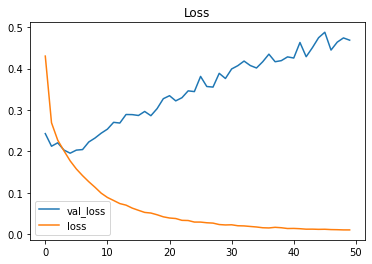

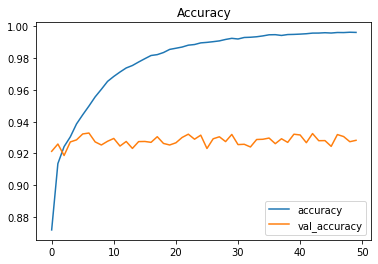

In [ ]:
import matplotlib.pyplot as plt

plt.plot(model_1_vals['val_loss'])
plt.plot(model_1_vals['loss'])
plt.legend(['val_loss', 'loss'])
plt.title('Loss')
plt.show()

plt.plot(model_1_vals['accuracy'])
plt.plot(model_1_vals['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.title('Accuracy')
plt.show()

In [ ]:
iter = 50
best_model_val = 0

#Saving models differently as there was consistent implementation error with google drive

model_2_vals = {}

for i in range(iter):
  print(f'Iteration: {i}')
  history = model_2.fit(X_train, y_train_2,
                    validation_data = (X_test, y_test_2),
                    epochs = 1,
                    #callbacks=callbacks,
                    batch_size=10,
                    verbose=1
                    )
  model_val = history.history['val_accuracy'][0]
  if model_val > best_model_val:
    model_2.save_weights(f'{checkpoint_dir}_2.h5')
    best_model_val = model_val
  
  for key in history.history.keys():
    if key not in model_2_vals:
      model_2_vals[key] = []
    model_2_vals[key].append(history.history[key][0])

model_2.load_weights(f'{checkpoint_dir}_2.h5')

Iteration: 0


30/30 [==============================] - 101s 568ms/step - loss: 10.5791 - accuracy: 0.0150 - val_loss: 7.9394 - val_accuracy: 0.0644
Iteration: 1
30/30 [==============================] - 5s 153ms/step - loss: 9.8871 - accuracy: 0.0192 - val_loss: 7.3389 - val_accuracy: 0.0842
Iteration: 2
30/30 [==============================] - 5s 152ms/step - loss: 8.9483 - accuracy: 0.0258 - val_loss: 6.6799 - val_accuracy: 0.1064
Iteration: 3
30/30 [==============================] - 4s 151ms/step - loss: 8.3787 - accuracy: 0.0408 - val_loss: 6.5551 - val_accuracy: 0.0916
Iteration: 4
30/30 [==============================] - 5s 160ms/step - loss: 8.0646 - accuracy: 0.0383 - val_loss: 6.4679 - val_accuracy: 0.1114
Iteration: 5
30/30 [==============================] - 5s 153ms/step - loss: 7.7396 - accuracy: 0.0467 - val_loss: 6.3957 - val_accuracy: 0.1089
Iteration: 6
30/30 [==============================] - 5s 175ms/step - loss: 7.3828 - accuracy: 0.0667 - val_loss: 6.2473 - val_accuracy: 0.1089
It

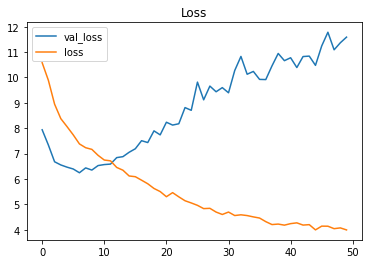

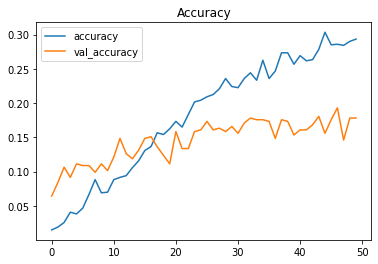

In [ ]:
import matplotlib.pyplot as plt

plt.plot(model_2_vals['val_loss'])
plt.plot(model_2_vals['loss'])
plt.legend(['val_loss', 'loss'])
plt.title('Loss')
plt.show()

plt.plot(model_2_vals['accuracy'])
plt.plot(model_2_vals['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.title('Accuracy')
plt.show()

In [ ]:
predictions_2 = model_2.predict(X_test)
predictions_1 = model.predict(X_test)

In [ ]:
for lay in model_2.layers:
  print(lay.name)

input_ids
attention_mask
token_type_ids
tf_bert_model_1
dropout_75
dense_1
permute
softmax_1


In [ ]:
_model_ = tf.keras.Model(model_2.input, model_2.get_layer('permute').output)

In [ ]:
_pred_ = _model_.predict(X_test)

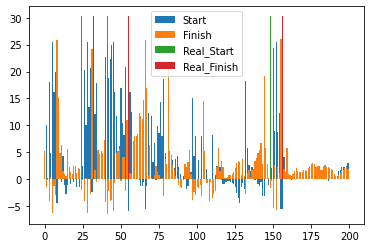

In [ ]:
import matplotlib.pyplot as plt

plt.bar(range(len(_pred_[0, 0, :200])), (_pred_[0, 0, :200] - _pred_[:, 0, :].mean()))
plt.bar(range(len(_pred_[0, 2, :200])), (_pred_[0, 2, :200] - _pred_[:, 2, :].mean()))
plt.bar(range(len(_pred_[0, 0, :200])), y_test_2[0, 0, :200]*_pred_[0, 0, :200].max())
plt.bar(range(len(_pred_[0, 2, :200])), y_test_2[0, 2, :200]*_pred_[0, 0, :200].max())

plt.legend(['Start', 'Finish', 'Real_Start', 'Real_Finish'])

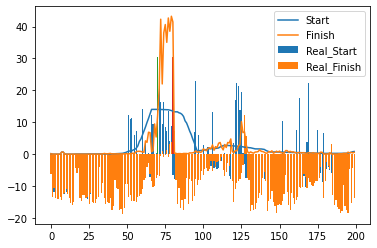

In [ ]:
num = 9
new = []
running = 15


for i in range(len(predictions_1[num, :, 1, 0])):
  val = predictions_1[num, :, 1, 0][i]
  if i > running:
    if i < (len(predictions_1[num, :, 1, 0])-running):
      val = predictions_1[num, :, 1, 0][(i-running):(i+running)].mean()
  new.append(val)

plt.plot(np.dot(50, new)[:200])
plt.plot(np.dot(50, predictions_1[num, :, 1,0])[:200])

#import matplotlib.pyplot as plt

plt.bar(range(len(_pred_[num, 0, :200])), (_pred_[num, 0, :200] - _pred_[:, 0, :].mean()))
plt.bar(range(len(_pred_[num, 2, :200])), (_pred_[num, 2, :200] - _pred_[:, 2, :].mean()))
plt.bar(range(len(_pred_[num, 0, :200])), y_test_2[num, 0, :200]*_pred_[:, 0, :200].max())
plt.bar(range(len(_pred_[num, 2, :200])), y_test_2[num, 2, :200]*_pred_[:, 0, :200].max())

plt.legend(['Start', 'Finish', 'Real_Start', 'Real_Finish'])

In [ ]:
import copy
num = 17

individual = copy.copy(predictions_1[num])
start_stop = copy.copy(_pred_[num])

def shortlist_individual(values, cutoff, length):
  zeros = np.zeros(len(values))
  for i in range(len(values)):
    val = values[i]
    if val > cutoff:
      start = i - length
      end = i + length
      if start < 0:
        start = 0
      else:
        if end >= len(values):
          end = len(values)-1
      zeros[start:end] = 1
  return zeros

def shortlist_individual_argmax(_values_, indexer, cutoff, length):
  
  values = copy.copy(_values_)

  for i in range(len(_values_)):
    zeros = np.zeros(_values_.shape[-1])
    argmaxer = _values_[i].argmax()
    zeros[argmaxer] = 1
    values[i] = zeros
  values = values[:, indexer]
  zeros = np.zeros(len(values))
  for i in range(len(values)):
    val = values[i]
    if val > cutoff:
      start = i - length
      end = i + length
      if start < 0:
        start = 0
      else:
        if end >= len(values):
          end = len(values)-1
      zeros[start:end] = 1
  return zeros, values

short, binary_vals = shortlist_individual_argmax(individual[:, 1], 0, 0.5, 6)

def evaluate_phrases(_X_, values, values_finish, averages, cutoff):

  _class_ = np.zeros(len(_X_))
  phrase_coordinates = []

  last_val = 0
  current_coor = []

  #Find Phrase Coordinates
  for i in range(len(values)):
    val = values[i]
    if val != 0:
      if last_val == 0:
        current_coor.append(i)
        current_coor.append(i)
      else:
        current_coor[1] = i
    else:
      if last_val != 0:
        phrase_coordinates.append(current_coor)
        current_coor = []
    last_val = val

  #Find start finish of Sentance
  extracts = []
  
  for coor in phrase_coordinates:
    st = coor[0]
    en = coor[1]

    starting_vals = values[st:en]
    ending_vals = values_finish[st:en]

    arg_st = starting_vals.argmax()
    arg_en = ending_vals.argmax()
    
    _st_ = st+arg_st
    _en_ = st+arg_en+1
    
    if _st_ <= en:
      mean = averages[_st_:_en_].mean()
      if mean > cutoff:
        extracts.append(_X_[_st_:_en_])
        _class_[_st_:_en_] = 1
  

  #Convert Tokens to Text
  texts = []
  for extract in extracts:
    texts.append(tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(extract)))

  return texts, _class_

In [ ]:
values = short*start_stop[0, :]
values_finish = short*start_stop[2, :]
test, _class_ = evaluate_phrases(X_test['input_ids'][num], values, values_finish, binary_vals, 0.5)
test

['security flaws in its microchips',
 'claim that users were harmed by intel \' s " actions and / or omissions " related to the flaws , which could allow hackers to steal data from computers',
 'allege that intel and some of its officers violated securities laws']

In [ ]:
type_diction = {
    'Reason':[[1, 0], [0, 2]],
    'Outcome':[[1, 1], [1, 3]]
    }

model_algo_results = {}

name_diction = []

identified_texts = {}

individuals = copy.copy(predictions_1)
start_stops = copy.copy(_pred_)

for key in type_diction.keys():
  for i in range(len(predictions_1)):
    individual = individuals[i]
    start_stop = start_stops[i]

    short, binary_vals = shortlist_individual_argmax(individual[:, 1], type_diction[key][0][1], 0.5, 3)
    
    values = short*start_stop[type_diction[key][1][0], :]
    values_finish = short*start_stop[type_diction[key][1][1], :]

    texts, _class_ = evaluate_phrases(X_test['input_ids'][i], values, values_finish, binary_vals, 0.5)

    _class_ = _class_[X_test['input_ids'][i] != 0]
    tester = y_test[i, :, 1, type_diction[key][0][1]]
    tester = tester[X_test['input_ids'][i] != 0]

    if key not in model_algo_results:
      model_algo_results[key] = {'Pred':[],
                                 'Actual':[]}
    model_algo_results[key]['Actual'] += _class_.tolist()
    model_algo_results[key]['Pred'] += tester.tolist()
    

    if i not in identified_texts:
      identified_texts[i] = {}
    
    identified_texts[i][key] = texts

identified_texts


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:88: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


{0: {'Outcome': [],
  'Reason': ['challenge to net neutrality',
   "challenging the fcc ' s rollback of net neutrality regulations"]},
 1: {'Outcome': [],
  'Reason': ['alleging the tech giant manipulates search results and advertising auctions in ways that harm online publishers',
   'alleges that google punishes publishers in search rankings if they donit sell enough advertising space through googleis marketplace .']},
 2: {'Outcome': ['won preliminary approval late on wednesday from a federal court for settlement',
   'raised its settlement offer by $ 100 million to $ 650 million',
   'preliminary approval of the class action settlement',
   'preliminary approval of the amended stipulation of class action settlement',
   '##8'],
  'Reason': ['illegally collected and stored biometric data of millions of users without their consent',
   "accused it of violating the u . s . state ' s biometric information privacy act",
   "allegedly violated the state ' s law"]},
 3: {'Outcome': ['laws

In [ ]:
num = 43
output = get_entities_argmax_altered(X_test['input_ids'][num], predictions_1[num, :, 0, :], 0.5)
output

[]

In [ ]:
test_output = get_entities_argmax_altered(X_test['input_ids'][num], y_test[num, :, 0, :], 0.5)
test_output

[['Plantiff', 'government'],
 ['Plantiff', 'hong kong'],
 ['Plantiff', 'hong kong'],
 ['Plantiff', 'hong kong'],
 ['Defendant', 'tong ying - kit'],
 ['Plantiff', 'hong kong'],
 ['Plantiff', 'hong kong'],
 ['Defendant', 'tong'],
 ['Plantiff', 'government'],
 ['Plantiff', 'hong kong'],
 ['Defendant', 'tong'],
 ['Plantiff', 'hong kong'],
 ['Plantiff', 'government'],
 ['Plantiff', 'government']]

In [ ]:
import pdb
def exact_match_check(y_pred, y_true):
  
  starter = False
  last_pred = False
  last_true = False
  outcome = []
  
  for i in range(len(y_pred)):
    if y_pred[i] == 1:
      pred_check = True
    else:
      pred_check = False
    
    if y_true[i] == 1:
      true_check = True
    else:
      true_check = False
    
    if true_check == True:
      if true_check != last_true:
        if pred_check != last_pred:
          if pred_check == True:
            checking = True
          else:
            checking = False
        else:
          checking = False
    
    if true_check == False:
      if true_check != last_true:
        if pred_check != last_pred:
          if pred_check == False:
            outcome.append(1)
          else:
            outcome.append(0)
        else:
          outcome.append(0)
    

    last_pred = pred_check
    last_true = true_check
  
  return np.array(outcome).sum()/len(outcome)

def partial_match_check(y_pred, y_true):
  
  starter = False
  open = False
  outcome = []
  
  for i in range(len(y_pred)):
    if y_pred[i] == 1:
      pred_check = True
    else:
      pred_check = False
    
    if y_true[i] == 1:
      true_check = True
    else:
      true_check = False
    
    if true_check == True:
      if open == False:
        open = True
        partial = False
    else:
      if open == True:
        if partial == True:
          outcome.append(1)
        else:
          outcome.append(0)
      open = False
    
    if open == True:
      if pred_check == True:
        partial = True
    
    last_pred = pred_check
    last_true = true_check
  
  return np.array(outcome).sum()/len(outcome)

In [ ]:

entity_diction = {
    "Plantiff":0,
    "Defendant":1,
    "No-Tag":2
}


metrics = {
    
}


predictions = model.predict(X_test)

for i in range(len(predictions)):
  for n in range(len(predictions[i])):
    for m in range(len(predictions[i][n])):
        new_z = predictions[i][n][m].argmax()
        zeros = np.zeros(len(predictions[i][n][m]))
        arg = predictions[i][n][m].argmax()
        zeros[arg] = 1
        predictions[i][n][m] = zeros

predictions = predictions[:, :, 0, :]
y_tester = y_test[:,:, 0, :]

for key in entity_diction.keys():
  val = entity_diction[key]
  metrics[key] = {'Pred':[],
                  'Actual':[]
                  }
  for i in range(len(X_test['input_ids'])):
    for n in range(len(X_test['input_ids'][i])):
        mask = X_test['attention_mask'][i][n]
        if mask == 1:
            pred = predictions[i][n][val]
            if ~np.isinf(pred):
              if ~np.isnan(pred):
                metrics[key]['Pred'].append(pred)
                metrics[key]['Actual'].append(y_tester[i][n][val])


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

outputer = {'Label':[],
            'Accuracy':[],
            'Precision':[],
            'Recall':[],
            'F1 Score':[],
            'Exact_Match_Precision':[],
            'Exact_Match_Recall':[],
            'Partial_Match_Precision':[],
            'Partial_Match_Recall':[]
            }

confusion_matrixs = {}

for key in metrics.keys():
    outputer['Label'].append(key)
    outputer['Accuracy'].append(accuracy_score(metrics[key]['Actual'], metrics[key]['Pred']))
    outputer['Precision'].append(precision_score(metrics[key]['Actual'], metrics[key]['Pred']))
    outputer['Recall'].append(recall_score(metrics[key]['Actual'], metrics[key]['Pred']))
    outputer['F1 Score'].append(f1_score(metrics[key]['Actual'], metrics[key]['Pred']))
    outputer['Exact_Match_Precision'].append(exact_match_check(metrics[key]['Actual'], metrics[key]['Pred']))
    outputer['Exact_Match_Recall'].append(exact_match_check(metrics[key]['Pred'], metrics[key]['Actual']))
    outputer['Partial_Match_Precision'].append(partial_match_check(metrics[key]['Actual'], metrics[key]['Pred']))
    outputer['Partial_Match_Recall'].append(partial_match_check(metrics[key]['Pred'], metrics[key]['Actual']))
    confusion_matrixs[key] = confusion_matrix(metrics[key]['Actual'], metrics[key]['Pred'])

In [ ]:
import pandas as pd
df = pd.DataFrame(outputer, columns=['Label', 'Accuracy','Precision', 'Recall', 'F1 Score', 'Exact_Match_Precision', 'Exact_Match_Recall', 'Partial_Match_Precision', 'Partial_Match_Recall'])
df

,Label,Accuracy,Precision,Recall,F1 Score,Exact_Match_Precision,Exact_Match_Recall,Partial_Match_Precision,Partial_Match_Recall
0,Plantiff,0.971661,0.588406,0.323506,0.417481,0.350820,0.278646,0.508197,0.369792
1,Defendant,0.970510,0.611111,0.818940,0.699924,0.516185,0.825175,0.587052,0.916084
2,No-Tag,0.960530,0.978915,0.978492,0.978703,0.621168,0.777879,0.972993,0.995430


In [ ]:
for key in confusion_matrixs.keys():
  print(key)
  print(confusion_matrixs[key])

Plantiff
[[38441   284]
 [  849   406]]
Defendant
[[37426   875]
 [  304  1375]]
No-Tag
[[ 2143   781]
 [  797 36259]]


In [ ]:

entity_diction = {
    "Reason":0,
    "Outcome":1,
    "No-Tag":2
}


metrics = {
    
}


predictions = model.predict(X_test)

for i in range(len(predictions)):
  for n in range(len(predictions[i])):
    for m in range(len(predictions[i][n])):
        new_z = predictions[i][n][m].argmax()
        zeros = np.zeros(len(predictions[i][n][m]))
        arg = predictions[i][n][m].argmax()
        zeros[arg] = 1
        predictions[i][n][m] = zeros

predictions = predictions[:, :, 1, :]
y_tester = y_test[:,:, 1, :]

for key in entity_diction.keys():
  val = entity_diction[key]
  metrics[key] = {'Pred':[],
                  'Actual':[]
                  }
  for i in range(len(X_test['input_ids'])):
    for n in range(len(X_test['input_ids'][i])):
        mask = X_test['attention_mask'][i][n]
        if mask == 1:
            pred = predictions[i][n][val]
            if ~np.isinf(pred):
              if ~np.isnan(pred):
                metrics[key]['Pred'].append(pred)
                metrics[key]['Actual'].append(y_tester[i][n][val])


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

outputer = {'Label':[],
            'Accuracy':[],
            'Precision':[],
            'Recall':[],
            'F1 Score':[],
            'Exact_Match_Precision':[],
            'Exact_Match_Recall':[],
            'Partial_Match_Precision':[],
            'Partial_Match_Recall':[]
            }

confusion_matrixs = {}

for key in metrics.keys():
    outputer['Label'].append(key)
    outputer['Accuracy'].append(accuracy_score(metrics[key]['Actual'], metrics[key]['Pred']))
    outputer['Precision'].append(precision_score(metrics[key]['Actual'], metrics[key]['Pred']))
    outputer['Recall'].append(recall_score(metrics[key]['Actual'], metrics[key]['Pred']))
    outputer['F1 Score'].append(f1_score(metrics[key]['Actual'], metrics[key]['Pred']))
    outputer['Exact_Match_Precision'].append(exact_match_check(metrics[key]['Actual'], metrics[key]['Pred']))
    outputer['Exact_Match_Recall'].append(exact_match_check(metrics[key]['Pred'], metrics[key]['Actual']))
    outputer['Partial_Match_Precision'].append(partial_match_check(metrics[key]['Actual'], metrics[key]['Pred']))
    outputer['Partial_Match_Recall'].append(partial_match_check(metrics[key]['Pred'], metrics[key]['Actual']))
    confusion_matrixs[key] = confusion_matrix(metrics[key]['Actual'], metrics[key]['Pred'])

In [ ]:
import pandas as pd
df = pd.DataFrame(outputer, columns=['Label', 'Accuracy','Precision', 'Recall', 'F1 Score', 'Exact_Match_Precision', 'Exact_Match_Recall', 'Partial_Match_Precision', 'Partial_Match_Recall'])
df

,Label,Accuracy,Precision,Recall,F1 Score,Exact_Match_Precision,Exact_Match_Recall,Partial_Match_Precision,Partial_Match_Recall
0,Reason,0.909455,0.573416,0.531265,0.551536,0.212903,0.430435,0.486022,0.665217
1,Outcome,0.959855,0.444912,0.358887,0.397296,0.050980,0.171053,0.396078,0.710526
2,No-Tag,0.879915,0.924060,0.937515,0.930738,0.078550,0.176271,0.782477,0.942373


In [ ]:
for key in confusion_matrixs.keys():
  print(key)
  print(confusion_matrixs[key])

Reason
[[34134  1656]
 [ 1964  2226]]
Outcome
[[37846   660]
 [  945   529]]
No-Tag
[[ 2921  2651]
 [ 2150 32258]]


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

outputer = {'Label':[],
            'Accuracy':[],
            'Precision':[],
            'Recall':[],
            'F1 Score':[],
            'Exact_Match_Precision':[],
            'Exact_Match_Recall':[],
            'Partial_Match_Precision':[],
            'Partial_Match_Recall':[]
            }

confusion_matrixs = {}

for key in model_algo_results.keys():
    outputer['Label'].append(key)
    outputer['Accuracy'].append(accuracy_score(model_algo_results[key]['Actual'], model_algo_results[key]['Pred']))
    outputer['Precision'].append(precision_score(model_algo_results[key]['Actual'], model_algo_results[key]['Pred']))
    outputer['Recall'].append(recall_score(model_algo_results[key]['Actual'], model_algo_results[key]['Pred']))
    outputer['F1 Score'].append(f1_score(model_algo_results[key]['Actual'], model_algo_results[key]['Pred']))
    outputer['Exact_Match_Precision'].append(exact_match_check(model_algo_results[key]['Actual'], model_algo_results[key]['Pred']))
    outputer['Exact_Match_Recall'].append(exact_match_check(model_algo_results[key]['Pred'], model_algo_results[key]['Actual']))
    outputer['Partial_Match_Precision'].append(partial_match_check(model_algo_results[key]['Actual'], model_algo_results[key]['Pred']))
    outputer['Partial_Match_Recall'].append(partial_match_check(model_algo_results[key]['Pred'], model_algo_results[key]['Actual']))
    confusion_matrixs[key] = confusion_matrix(model_algo_results[key]['Actual'], model_algo_results[key]['Pred'])

In [ ]:
import pandas as pd
df = pd.DataFrame(outputer, columns=['Label', 'Accuracy','Precision', 'Recall', 'F1 Score', 'Exact_Match_Precision', 'Exact_Match_Recall', 'Partial_Match_Precision', 'Partial_Match_Recall'])
df

,Label,Accuracy,Precision,Recall,F1 Score,Exact_Match_Precision,Exact_Match_Recall,Partial_Match_Precision,Partial_Match_Recall
0,Reason,0.909830,0.465871,0.588129,0.519909,0.400000,0.431925,0.573913,0.624413
1,Outcome,0.963357,0.234735,0.506589,0.320816,0.184211,0.170732,0.526316,0.500000


In [ ]:
for key in confusion_matrixs.keys():
  print(key)
  print(confusion_matrixs[key])

Reason
[[34423  2238]
 [ 1367  1952]]
Outcome
[[38169  1128]
 [  337   346]]
